# TP7: Décomposition QR

La décomposition QR est une décomposition centrale en analyse numérique. Elle est principalement utilisée pour trouver une base de l'image d'une matrice, mais elle est aussi utilisée pour résoudre des systèmes linéaires, pour calculer les valeurs propres d'une matrice, etc.

Au programme de ce TP:
- Introduction à la décomposition QR
  - Fonctions de numpy et scipy
  - Propriétés de la décomposition QR
- Algorithmes de décomposition QR
  - Gram-Schmidt
  - Gram-Schmidt modifié
  - Householder
- Stabilité numérique des algorithmes
- Application à la résolution de systèmes linéaires
- Bonus: Algorithme de Givens

## Échauffement: Introduction à la décomposition QR

Commençons par nous familiariser avec la décomposition QR. 

La décomposition QR d'une matrice $A$ est une décomposition de la forme 
$$A = QR$$ 
où $Q$ est une matrice orthogonale et $R$ est une matrice triangulaire supérieure.

Les deux principaux packages de Python pour le calcul scientifique sont `numpy` et `scipy`. Chaque package contient des fonctions pour calculer la décomposition QR. 
- Pour numpy, la fonction est `numpy.linalg.qr`. La documentation est disponible [ici](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.qr.html).
- Pour scipy, la fonction est `scipy.linalg.qr`. La documentation est disponible [ici](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.qr.html).

Comme vous pouvez le voir dans la documentation, `scipy` offre plus de possibilités que `numpy`. Nous l'utiliserons donc pour ce TP.

### Exercice 0.1

Après avoir importé numpy et scipy, générez une matrice aléatoire $A$ de taille $4 \times 3$ et calculez la décomposition QR de $A$ avec la fonction `scipy.linalg.qr`. Affichez les matrices $Q$ et $R$.

Comparez les résultats en ajoutant l'argument `mode='economic'` à la fonction `scipy.linalg.qr`. Quelle est la différence entre les deux décompositions?


In [25]:
import numpy as np
import scipy as sp
# VOTRE CODE ICI
A = np.random.randn(4, 3)

Q, R = sp.linalg.qr(A)

print('Q:', Q)
print('R:', R)

Q: [[-0.1520989  -0.54943889 -0.68087615 -0.45977222]
 [ 0.59778522 -0.31965845 -0.3219011   0.66094704]
 [-0.04643268  0.75040484 -0.65363658  0.08657833]
 [-0.78572436 -0.18118486 -0.07447536  0.58673904]]
R: [[-1.75524469  0.48952059  1.00422732]
 [ 0.         -1.06550254  0.33943285]
 [ 0.          0.          1.3356733 ]
 [ 0.          0.          0.        ]]


### Exercice 0.2

Vérifiez les propriétés suivantes de la décomposition QR:
- $A = QR$.
- $Q$ est orthogonale.
- $||A||_F = ||R||_F$.

In [26]:
# VOTRE CODE ICI

# A = QR
assert np.allclose(A, np.dot(Q, R)), 'A != QR'
print('A == QR, OK')

# Q est orthogonale
assert np.allclose(np.dot(Q.T, Q), np.eye(Q.shape[1])), "Q n'est pas orthogonale"
print('Q est orthogonale, OK')

# Norme de A et R
print('||A||_F:', np.linalg.norm(A, ord='fro'))
print('||R||_F:', np.linalg.norm(R, ord='fro'))
print('||A|| - ||R||:', np.linalg.norm(A, ord='fro') - np.linalg.norm(R, ord='fro'))

A == QR, OK
Q est orthogonale, OK
||A||_F: 2.7135807216376153
||R||_F: 2.7135807216376153
||A|| - ||R||: 0.0


## Exercice 1: Algorithmes de décomposition QR

Le but de cet exercice est d'implémenter soi-même les différents algorithmes de décomposition QR vus en cours.

### Exercice 1.1: Méthode de Gram-Schmidt

Implémentez une fonction `GramSchmidt` qui prend en argument une matrice $A$ et qui renvoie la matrice $Q$ telle que $$A = QR,$$ où $Q$ est une matrice orthogonale et $R$ est une matrice triangulaire supérieure, au moyen de la procédure d'orthogonalisation de Gram-Schmidt. 

Voir l'algorithme 6.6 du polycopié.

Comme lors de l'échauffement, testez votre code sur une matrice aléatoire de taille $4 \times 3$ en vérifiant les propriétés de $Q$ et $R$, et $||A - QR||_2$.


In [27]:
def GramSchmidt(A):
    """
    Décomposition QR de A par la méthode de Gram-Schmidt classique (non stable).

    Entrées
    -------
    A : ndarray
        Matrice de taille m x n. (m >= n)

    Sorties
    -------
    Q : ndarray
        Matrice orthogonale de taille m x n.
    R : ndarray
        Matrice triangulaire supérieure de taille n x n.
    """
    m, n = A.shape
    Q = np.zeros((m,n))
    R = np.zeros((n,n))
    # VOTRE CODE ICI
    for j in np.arange(n):
        Q[:,j] = A[:,j]
        for i in np.arange(j):
            R[i,j] = A[:,j].T.dot(Q[:,i])
            Q[:,j] -= R[i,j] * Q[:,i]
        R[j,j] = np.linalg.norm(Q[:,j], 2)
        Q[:,j] /= R[j,j]
    return Q, R


In [28]:
# VOTRE TEST ICI
np.random.seed(0)
A = np.random.randn(4, 3)
Q, R = GramSchmidt(A)

# Check if A = QR
print("Error = ", np.linalg.norm(A - Q @ R, 2))

# Check if Q is orthogonal
print("Error = ", np.linalg.norm(Q.T @ Q - np.eye(Q.shape[1]), 2))



Error =  1.3656389837035794e-16
Error =  1.9818202994499187e-16


In [29]:
# TEST AUTOMATIQUE
from numpy.testing import assert_allclose
from numpy.random import randn
from tqdm import tqdm

all_m = np.linspace(10, 100, 10, dtype=int)
all_n = np.linspace(10, 100, 10, dtype=int)

for m, n in tqdm(zip(all_m, all_n)):
    if m < n:
        continue
    A = randn(m, n)
    Q, R = GramSchmidt(A)
    # Check that A = QR
    assert_allclose(A, Q @ R, atol=1e-10, err_msg="A != QR")
    # Note: with Gram-Schmidt, Q is not necessarily orthogonal

print("Tests automatiques passés avec succès.")

10it [00:00, 102.73it/s]

Tests automatiques passés avec succès.


### Exercice 1.2: Décomposition QR par la méthode de Gram-Schmidt modifiée

Similairement à la question précédente, écrire une fonction `GramSchmidtMod` qui utilise la méthode de Gram-Schmidt modifiée.

Voir l'Algorithme 6.7 du polycopié.

Comme précédemment, testez simplement votre code sur une matrice $4 \times 3$. 
Nous verrons dans l'exercice 1.4 que la méthode de Gram-Schmidt modifiée est plus stable numériquement que la méthode de Gram-Schmidt.

In [30]:
def GramSchmidtMod(A):
    """
    Décomposition QR de A par la méthode de Gram-Schmidt modifiée (stable).

    Entrées
    -------
    A : ndarray
        Matrice de taille m x n. (m >= n)

    Sorties
    -------
    Q : ndarray
        Matrice orthogonale de taille m x n.
    R : ndarray
        Matrice triangulaire supérieure de taille n x n.
    """
    m, n = A.shape
    Q = np.zeros((m,n))
    R = np.zeros((n,n))
    # VOTRE CODE ICI
    for i in np.arange(n):
        Q[:,i] = A[:,i]
    for i in np.arange(n):
        R[i,i] = np.linalg.norm(Q[:,i])
        Q[:,i] /= R[i,i]
        for j in np.arange(i+1, n):
            R[i,j] = Q[:,i].T @ Q[:,j]
            Q[:,j] -= R[i,j] * Q[:,i]
    return Q, R


In [31]:
# VOTRE TEST ICI
np.random.seed(0)
A = np.random.randn(4, 3)
Q, R = GramSchmidtMod(A)

# Check if A = QR
print("Error = ", np.linalg.norm(A - Q @ R, 2))

# Check if Q is orthogonal
print("Error = ", np.linalg.norm(Q.T @ Q - np.eye(Q.shape[1]), 2))



Error =  1.3656389837035794e-16
Error =  1.9818202994499187e-16


In [32]:
# TEST AUTOMATIQUE
from numpy.testing import assert_allclose
from numpy.random import randn
from tqdm import tqdm

all_m = np.linspace(10, 100, 10, dtype=int)
all_n = np.linspace(10, 100, 10, dtype=int)

for m, n in tqdm(zip(all_m, all_n)):
    if m < n:
        continue
    A = randn(m, n)
    Q, R = GramSchmidtMod(A)
    # Check that A = QR
    assert_allclose(A, Q @ R, atol=1e-10, err_msg="A != QR")
    # Note: with modified Gram-Schmidt, Q is not necessarily orthogonal

print("Tests automatiques passés avec succès.")

10it [00:00, 100.56it/s]

Tests automatiques passés avec succès.


### Exercice 1.3: Décomposition QR par la méthode de Householder

Écrire une fonction `Householder` qui calcule la décomposition QR d'une matrice $A$ par la méthode de Householder.

Voir l'algorithme 6.11 du polycopié.

Dans cet algorithme, la mise à jour de $R$ est donnée par 
$$R_{k:m,k} = R_{k:m,k} - 2 v_k (v_k^T R_{k:m,k}).$$
Similairement, on peut obtenir (comment?) que la mise à jour de $Q$ est donnée par
$$Q_{k,k:m} = Q_{k,k:m} - 2 v_k (v_k^T Q_{k,k:m}).$$


In [33]:
def Householder(A):
    """
    Décomposition QR de A par la méthode de Householder.

    Entrées
    -------
    A : ndarray
        Matrice de taille m x n. (m >= n)

    Sorties
    -------
    Q : ndarray
        Matrice orthogonale de taille m x n.
    R : ndarray
        Matrice triangulaire supérieure de taille n x n.
    """
    m, n = A.shape
    Q = np.eye(m)
    R = A.copy()
    # VOTRE CODE ICI
    for k in np.arange(n):
        x = R[k:,k]
        e = np.zeros(x.shape)
        e[0] = 1
        vk = x + np.sign(x[0]) * np.linalg.norm(x) * e
        norm_vk = np.linalg.norm(vk)
        if norm_vk != 0:
            vk /= np.linalg.norm(vk)
        for j in np.arange(k, n):
            R[k:,j] -= 2 * vk * (vk.T @ R[k:,j])
        for i in np.arange(m):
            Q[i,k:] -= 2 * vk * (vk.T @ Q[i,k:])
    return Q, R

In [34]:
# VOTRE TEST ICI
np.random.seed(0)
A = np.random.randn(4, 3)
Q, R = Householder(A)

# Check Q and R
print("Q = \n", Q)
print("R = \n", R)

# Check if A = QR
print("Error = ", np.linalg.norm(A - Q @ R, 2))

# Check if Q is orthogonal
print("Error = ", np.linalg.norm(Q.T @ Q - np.eye(Q.shape[1]), 2))

Q = 
 [[-0.581441    0.47915974  0.25929548 -0.60423352]
 [-0.73861028 -0.64154205 -0.15752491  0.13440445]
 [-0.31315418  0.59551882 -0.46848788  0.57254773]
 [-0.13533544  0.06470756  0.82974144  0.53761175]]
R = 
 [[-3.03393180e+00 -1.58416139e+00 -1.17422449e-02]
 [ 0.00000000e+00 -1.08719312e+00  1.12857042e+00]
 [ 0.00000000e+00  1.11022302e-16  1.66275572e+00]
 [-5.55111512e-17  6.93889390e-18  0.00000000e+00]]
Error =  2.005523636643519e-15
Error =  1.4546056250132197e-15


In [35]:
# TEST AUTOMATIQUE
from numpy.testing import assert_allclose
from numpy.random import randn
from tqdm import tqdm

all_m = np.linspace(10, 100, 10, dtype=int)
all_n = np.linspace(10, 100, 10, dtype=int)

for m, n in tqdm(zip(all_m, all_n)):
    if m < n:
        continue
    A = randn(m, n)
    Q, R = Householder(A)
    # Check that A = QR
    assert_allclose(A, Q @ R, atol=1e-10, err_msg="A != QR")
    # Check that Q is orthogonal
    assert_allclose(Q.T @ Q, np.eye(Q.shape[1]), atol=1e-10, err_msg="Q is not orthogonal")

print("Tests automatiques passés avec succès.")


10it [00:00, 20.76it/s]

Tests automatiques passés avec succès.


## Exercice 2 : Stabilité numérique

Dans cet exercice, nous allons comparer la stabilité numérique des différents algorithmes de décomposition QR. Plus particulièrement, nous allons étudier l'orthogonalité des matrices $Q$ obtenues. Si ces matrices ne sont pas orthogonales, c'est suffisant pour montrer que la méthode correspondante n'est pas numériquement stable.

Pour cela, nous allons utiliser des matrices particulières. Pour $n=5$, la matrice de Frank $F_5$ est définie par $$F_5 = \begin{pmatrix} 1 & 1 & 1 & 1 & 1 \\ 1 & 2 & 2 & 2 & 2 \\ 0 & 2 & 3 & 3 & 3 \\ 0 & 0 & 3 & 4 & 4 \\ 0 & 0 & 0 & 4 & 5 \end{pmatrix}.$$

Le code ci-dessous permet de générer une matrice de Frank de taille $n \times n$.

Fixons $n=50$. Pour comparer les méthodes, considérons les matrices $$A_{50} = F_{50} + \alpha I_{50}, \quad \text{ où } \alpha \in [1, 10].$$


F = 
 [[1. 1. 1. 1. 1.]
 [1. 2. 2. 2. 2.]
 [0. 2. 3. 3. 3.]
 [0. 0. 3. 4. 4.]
 [0. 0. 0. 4. 5.]]


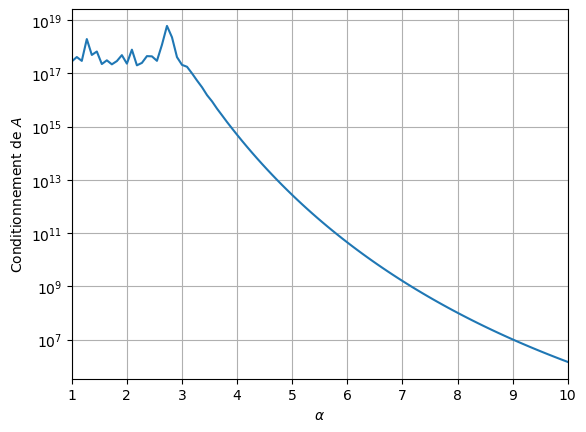

In [36]:
def generate_Frank(n):
    """
    Génère la matrice de Frank de taille n x n.
    """
    F = np.zeros((n,n))
    for i in np.arange(n):
        for j in np.arange(n):
            if j < i-1:
                F[i,j] = 0
            elif j == i-1:
                F[i,j] = i
            else:
                F[i,j] = i + 1
    return F

# Matrice de Frank de taille 5 x 5
F = generate_Frank(5)
print("F = \n", F)

# Paramètres
n = 50
list_alpha = np.linspace(1, 10, 100)
Fn = generate_Frank(n)
In = np.eye(n)

# Boucle sur alpha
cond_A = np.zeros_like(list_alpha)
for i, alpha in enumerate(list_alpha):
    A = Fn + alpha * In
    cond_A[i] = np.linalg.cond(A)

# Plot du conditionnement en fonction de alpha
import matplotlib.pyplot as plt
plt.figure()
plt.semilogy(list_alpha, cond_A)
plt.grid()
plt.xlabel(r"$\alpha$")
plt.xlim(list_alpha[0], list_alpha[-1])
plt.ylabel(r"Conditionnement de $A$")
plt.show()

Comme on peut le voir sur le graphique ci-dessus, la conditionnement de la matrice $A_{50}$ est très élevé. Par conséquent, si l'on utilise une méthode de décomposition QR non stable, les erreurs d'arrondi peuvent se propager et conduire à des résultats faussés. 

### Exercice 2.1 : Stabilité numérique

Pour plusieurs valeurs $\alpha \in [1, 10]$:
- Calculez la décomposition QR de $A_{50}$ avec les méthodes implémentées dans les exercices précédents et la fonction `scipy.linalg.qr`.
- Pour chaque méthode, tracez $||Q^T Q - I_{50}||_1$ en fonction de $\alpha$. 
- Commentez les résultats.

Indication: Utilisez une échelle logarithmique pour l'axe des ordonnées avec `plt.semilogy`.

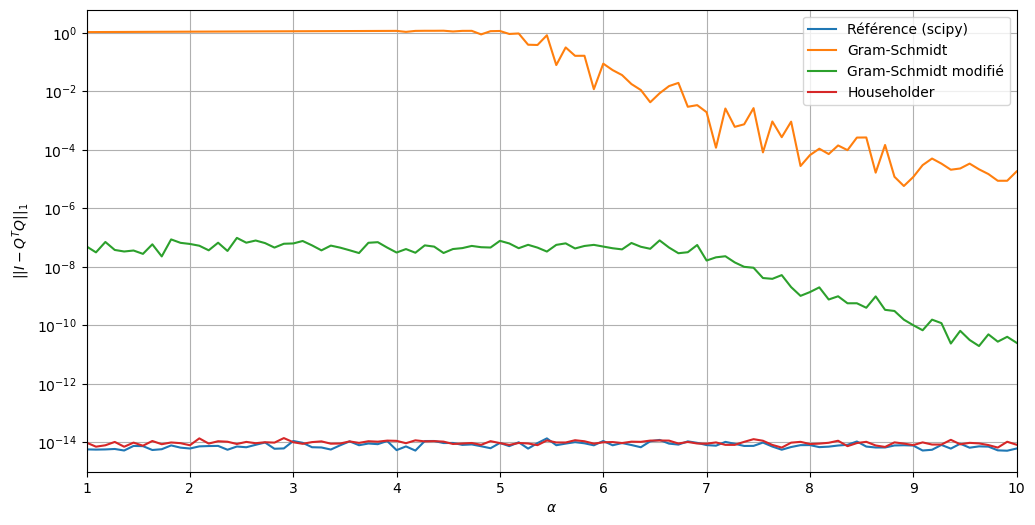

In [37]:
# Paramètres
n = 50
nb_alpha = 100
list_alpha = np.linspace(1, 10, nb_alpha)
Fn = generate_Frank(n)
In = np.eye(n)

# Boucle sur alpha
err_ref = np.zeros_like(list_alpha)
err_gm = np.zeros_like(list_alpha)
err_gmm = np.zeros_like(list_alpha)
err_h = np.zeros_like(list_alpha)
for i, alpha in enumerate(list_alpha):
    A = Fn + alpha * In
    # VOTRE CODE ICI

    # Reference
    Q_ref, R_ref = sp.linalg.qr(A)
    err_ref[i] = np.linalg.norm(In - Q_ref.T @ Q_ref, ord=1)

    # Gram-Schmidt
    Q_gm, R_gm = GramSchmidt(A)
    err_gm[i] = np.linalg.norm(In - Q_gm.T @ Q_gm, ord=1)

    # Gram-Schmidt modifié
    Q_gmm, R_gmm = GramSchmidtMod(A)
    err_gmm[i] = np.linalg.norm(In - Q_gmm.T @ Q_gmm, ord=1)

    # Householder
    Q_h, R_h = Householder(A)
    err_h[i] = np.linalg.norm(In - Q_h.T @ Q_h, ord=1)

# Plot
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12, 6))
plt.semilogy(list_alpha, err_ref, label="Référence (scipy)")
plt.semilogy(list_alpha, err_gm, label="Gram-Schmidt")
plt.semilogy(list_alpha, err_gmm, label="Gram-Schmidt modifié")
plt.semilogy(list_alpha, err_h, label="Householder")
plt.grid()
plt.xlabel(r"$\alpha$")
plt.xlim(list_alpha[0], list_alpha[-1])
plt.ylabel(r"$||I - Q^T Q||_1$")
plt.legend()
plt.show()


*Votre réponse ici*

Comme on peut le voir sur le graphique ci-dessus:
- La méthode de Gram-Schmidt est la plus instable. Lorsque le conditionnement de $A$ est élevé, la matrice $Q$ n'est absolument pas orthogonale.
- La méthode de Gram-Schmidt modifiée est plus stable. Cependant, l'orthogonalité de $Q$ n'est toujours pas garantie au niveau de la précision machine.
- La méthode de Householder est la plus stable. L'orthogonalité de $Q$ est garantie, même lorsque le conditionnement de $A$ est élevé.



## Exercice 3: Application à la résolution de systèmes linéaires

La décomposition QR peut être utilisée pour résoudre des systèmes linéaires. En effet,
$$A x = b \iff QR x = b \iff R x = Q^T b.$$
De plus, comme $R$ est triangulaire supérieure, on peut résoudre le système $Rx = y$ facilement (voir TP5). On pourra utiliser la fonction `scipy.linalg.solve_triangular` pour cela.

### Exercice 3.1

Écrire une fonction `QRsolve` qui prend en argument une matrice $A$ et un vecteur $b$ et qui renvoie la solution du système $Ax = b$. Utiliser l'argument `mode` pour choisir la méthode de décomposition QR à utiliser.


In [38]:
def QRsolve(A, b, mode):
    """
    Résolution du système linéaire Ax = b par la méthode QR.
    """
    # VOTRE CODE ICI
    if mode == "GramSchmidt":
        Q, R = GramSchmidt(A)
    elif mode == "GramSchmidtMod":
        Q, R = GramSchmidtMod(A)
    elif mode == "Householder":
        Q, R = Householder(A)
    elif mode == "scipy":
        Q, R = sp.linalg.qr(A)
    else:
        raise ValueError("Mode inconnu.")
    x = sp.linalg.solve_triangular(R, Q.T @ b)
    return x



### Exercice 3.2

Testez votre méthode avec les trois algorithmes sur le système linéaire suivant:

$$A = \begin{pmatrix} 2 & 1 & 3 \\ 2 & 6 & 8 \\ 6 & 8 & 18 \end{pmatrix}, \quad b = \begin{pmatrix} 2 \\ 3 \\ 1 \end{pmatrix}.$$

La solution exacte est $x = \begin{pmatrix} \frac{12}{5} & \frac{17}{10} & -\frac{3}{2} \end{pmatrix}^T$.

In [39]:
# Données
A = np.array([[2, 1, 3], [2, 6, 8], [6, 8, 18]], dtype=float)
b = np.array([2, 3, 1], dtype=float)
x_ref = np.array([12/5, 17/10, -3/2], dtype=float)

# VOTRE CODE ICI
x_gm = QRsolve(A, b, "GramSchmidt")
x_gmm = QRsolve(A, b, "GramSchmidtMod")
x_h = QRsolve(A, b, "Householder")

# Tests
print("Erreur Gram-Schmidt = ", np.linalg.norm(x_ref - x_gm, 2))
print("Erreur Gram-Schmidt modifié = ", np.linalg.norm(x_ref - x_gmm, 2))
print("Erreur Householder = ", np.linalg.norm(x_ref - x_h, 2))


Erreur Gram-Schmidt =  3.978256139440565e-15
Erreur Gram-Schmidt modifié =  5.760335218184685e-15
Erreur Householder =  8.972910126548661e-15


### Exercice 3.3

Pour $n=50$, considérons le système linéaire $$A_{50} x = b_{50},$$ où $A_{50}$ est la matrice de Frank de taille $50 \times 50$ et $b_{50}$ est un vecteur aléatoire de taille $50$.

- Que fait le code ci-dessous?
- Éditez le code pour comparer les trois méthodes de décomposition QR implémentées pour résoudre les systèmes linéaires.
- Commentez les résultats.

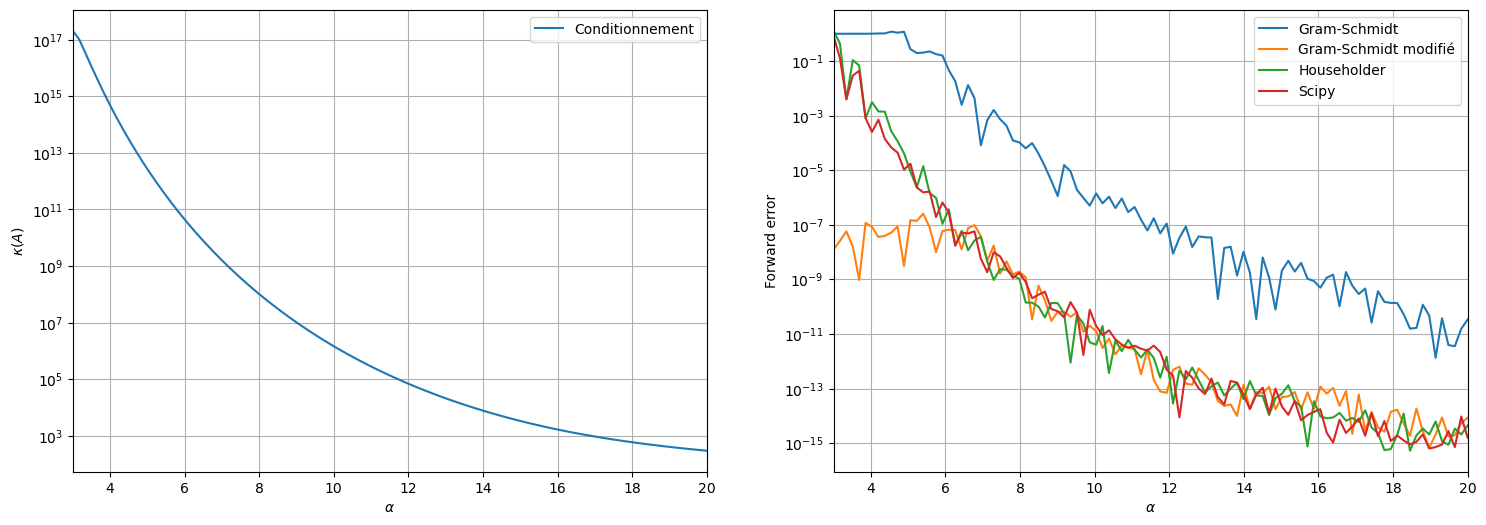

In [40]:
# Paramètres
n = 50
np.random.seed(0)
b = np.random.randn(n)
list_alpha = np.linspace(3, 20, 100)

# Initialisation
cond_A = np.zeros_like(list_alpha)
forward_err_gm = np.zeros_like(list_alpha)
forward_err_gmm = np.zeros_like(list_alpha)
forward_err_h = np.zeros_like(list_alpha)
forward_err_scipy = np.zeros_like(list_alpha)

# Boucle sur alpha
for i, alpha in enumerate(list_alpha):
    A = Fn + alpha * In
    cond_A[i] = np.linalg.cond(A)

    # Reference
    x_ref = np.linalg.solve(A, b)

    # Gram-Schmidt
    x_gm = QRsolve(A, b, "GramSchmidt")
    forward_err_gm[i] = np.linalg.norm(x_ref - x_gm, 2) / np.linalg.norm(x_ref, 2)

    # Gram-Schmidt modifié
    x_gmm = QRsolve(A, b, "GramSchmidtMod")
    forward_err_gmm[i] = np.linalg.norm(x_ref - x_gmm, 2) / np.linalg.norm(x_ref, 2)

    # Householder
    x_h = QRsolve(A, b, "Householder")
    forward_err_h[i] = np.linalg.norm(x_ref - x_h, 2) / np.linalg.norm(x_ref, 2)

    # Scipy
    x_scipy = QRsolve(A, b, "scipy")
    forward_err_scipy[i] = np.linalg.norm(x_ref - x_scipy, 2) / np.linalg.norm(x_ref, 2)


# Plot
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.semilogy(list_alpha, cond_A, label="Conditionnement")
plt.grid()
plt.xlabel(r"$\alpha$")
plt.xlim(list_alpha[0], list_alpha[-1])
plt.ylabel(r"$\kappa(A)$")
plt.legend()

plt.subplot(122)
plt.semilogy(list_alpha, forward_err_gm, label="Gram-Schmidt")
plt.semilogy(list_alpha, forward_err_gmm, label="Gram-Schmidt modifié")
plt.semilogy(list_alpha, forward_err_h, label="Householder")
plt.semilogy(list_alpha, forward_err_scipy, label="Scipy")
plt.grid()
plt.xlabel(r"$\alpha$")
plt.xlim(list_alpha[0], list_alpha[-1])
plt.ylabel("Forward error")
plt.legend()


plt.show()



*Votre réponse ici*

On observe que l'erreur forward augmente proportionnellement au conditionnement de la matrice $A$. Malheureusement, on ne peut rien faire pour réduire cette erreur.

## Exercice 4 (Bonus): Algorithme de Givens

Dans la série 15, un exercice porte sur l'algorithme de Givens. Cet algorithme permet de calculer la décomposition QR d'une matrice $A$ en effectuant des rotations de Givens sur les colonnes de $A$.

Dans certains cas, comme pour les matrices de Frank, l'algorithme de Givens est plus efficace que la méthode de Householder.

### Exercice 4.1

Comme dans la série 15, écrire une fonction `Givens_rotation` qui prend en argument deux scalaires $a$ et $b$ et qui renvoie la matrice de rotation de Givens correspondante.

In [41]:
def Givens_rotation(a, b):
    """
    Calcul de la matrice de rotation de Givens.
    """
    # VOTRE CODE ICI
    if b == 0:
        c = 1
        s = 0
    elif a == 0:
        c = 0
        s = 1
    elif abs(b) > abs(a):
        t = - a / b
        s = 1 / np.sqrt(1 + t**2)
        c = s * t
    else:
        t = - b / a
        c = 1 / np.sqrt(1 + t**2)
        s = c * t
    return c, s

In [42]:
# TEST AUTOMATIQUE
from numpy.testing import assert_allclose
# Cas b = 0
c, s = Givens_rotation(1, 0)
assert_allclose(c, 1, err_msg="Problème avec c lorsque b = 0")
assert_allclose(s, 0, err_msg="Problème avec s lorsque b = 0")
# Cas b > a
c, s = Givens_rotation(1, 2)
assert_allclose(s, 1 / np.sqrt(5/4), err_msg="Problème avec s lorsque b > a")
assert_allclose(c, - 1/2 * 1 / np.sqrt(5/4), err_msg="Problème avec c lorsque b > a")
# Cas b < a
c, s = Givens_rotation(2, 1)
assert_allclose(c, 1 / np.sqrt(5/4), err_msg="Problème avec c lorsque b < a")
assert_allclose(s, - 1/2 * 1 / np.sqrt(5/4), err_msg="Problème avec s lorsque b < a")

print("Tests passés avec succès !")

Tests passés avec succès !


### Exercice 4.2

Écrire une fonction `Givens` qui calcule la décomposition QR d'une matrice $A$ par l'algorithme de Givens.

In [43]:
def Givens(A):
    """
    Décomposition QR par la méthode de Givens.
    """
    m, n = A.shape
    Q = np.eye(m)
    R = A.copy()
    # VOTRE CODE ICI
    for j in range(n):
        for i in range(m-1, j, -1):
            if R[i, j] != 0:
                c, s = Givens_rotation(R[i-1, j], R[i, j])
                G = np.eye(m)
                G[i-1, i-1] = c
                G[i, i] = c
                G[i-1, i] = s
                G[i, i-1] = -s
                R = G @ R
                Q = Q @ G.T
    return Q, R

In [44]:
# TEST AUTOMATIQUE
from numpy.testing import assert_allclose
from numpy.random import randn
from tqdm import tqdm

np.random.seed(0)
all_m, all_n = 10 * np.random.randint(1, 10, size=(2, 100))

for m, n in tqdm(zip(all_m, all_n)):
    A = randn(m, n)
    Q, R = Givens(A)
    # Check that A = QR
    assert_allclose(A, Q @ R, atol=1e-10, err_msg="A != QR")
    # Check that Q is orthogonal
    assert_allclose(Q.T @ Q, np.eye(Q.shape[1]), atol=1e-10, err_msg="Q is not orthogonal")

print("Tests automatiques passés avec succès.")

100it [00:03, 32.07it/s]

Tests automatiques passés avec succès.


### Exercice 4.3

Considérons la matrice $A_{50}$ de l'exercice 3, avec $\alpha = 1$.

- Comparer la stabilité numérique de la méthode de Householder et de l'algorithme de Givens en calculant $||Q^T Q - I_{50}||_1$.
- Comparer le temps de calcul de chaque méthode avec la commande `%timeit`.

**Remarque:** Le temps de calcul dépend de votre implémentation. Pour optimiser votre méthode, vous pouvez économiser des calculs en détectant les cas où $b = 0$.

In [45]:
n = 50
Fn = generate_Frank(n)
In = np.eye(n)
A = Fn + In

# Stabilité numérique
# VOTRE CODE ICI
# Householder
Q_h, R_h = Householder(A)

# Givens
Q_g, R_g = Givens(A)

# Check Q est orthogonale
print("Q_h est orthogonale : ", np.linalg.norm(Q_h.T @ Q_h - np.eye(n), 1))
print("Q_g est orthogonale : ", np.linalg.norm(Q_g.T @ Q_g - np.eye(n), 1))



Q_h est orthogonale :  9.685313725990363e-15
Q_g est orthogonale :  8.345668333402339e-16


In [46]:
# Temps de calcul
print('Scipy:')
%timeit sp.linalg.qr(A)
# VOTRE CODE ICI
print("Householder:")
%timeit Householder(A)
print("Givens:")
%timeit Givens(A)

Scipy:
54.5 µs ± 6.61 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Householder:
22 ms ± 5.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Givens:
1.27 ms ± 225 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
